<a href="https://colab.research.google.com/github/sudeep-009/Retail-Sales-Prediction/blob/dev/Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [235]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
rossmann_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Capstone Projects/Regression Capstone-Retail Sales Prediction/Rossmann Stores Data.csv')

In [88]:
stores_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AlmaBetter/Capstone Projects/Regression Capstone-Retail Sales Prediction/store.csv')


###**Exploratory Data Analysis**

###Rossmann Stores Data
Lets first inspect the dataset here the main steps would be:
1.  Going through the first 5 and bottom 5 rows of the dataset.
2.  Finding out number of features and number of records present in the dataset.
3.  Features names present in the dataset.
2.  Finding out nulls present in the dataset.
3.  Finding the outlier present.
4.  Understanding the distribution of variables present in the dataset.
5.  Finding out the categorical and numerical variable present in the dateset.

**Going through first 5 and bottom 5 rows of the dataset**

In [89]:
pd.concat([rossmann_df.head(),rossmann_df.tail()])

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


**Number of features and number of records present in the dataset**

In [90]:
print('Number of records present in the dataset is {}'.format(rossmann_df.shape[0]))
print('Number of features present in the dataset is {}'.format(rossmann_df.shape[1]))

Number of records present in the dataset is 1017209
Number of features present in the dataset is 9


**Checking for duplicated items present in the dataset**

In [91]:
print('Number of  duplicate items present in the dataset is {}'.format(len(rossmann_df[rossmann_df.duplicated()])))

Number of  duplicate items present in the dataset is 0


**Datatype of columns present in the dataset**

In [92]:
rossmann_df.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

**Findings:** Date and StateHoliday is of categorical type

**Unique Element present in columns like DayofWeek, Open, Promo, StateHoliday, SchoolHoliday**

In [93]:
columns = ['DayOfWeek','Open','Promo','StateHoliday','SchoolHoliday']
for i in columns:
  print('Unique elements present in feature {} are {}'.format(i,rossmann_df[i].unique()))

Unique elements present in feature DayOfWeek are [5 4 3 2 1 7 6]
Unique elements present in feature Open are [1 0]
Unique elements present in feature Promo are [1 0]
Unique elements present in feature StateHoliday are ['0' 'a' 'b' 'c' 0]
Unique elements present in feature SchoolHoliday are [1 0]


**Findings:** We can treat the above features as categorical in nature

**Features name present in the dataset**

In [94]:
for i in rossmann_df.columns:
  print(i)

Store
DayOfWeek
Date
Sales
Customers
Open
Promo
StateHoliday
SchoolHoliday


**Finding out nulls present in the dataset**

In [95]:
print('Count of Nulls present in the dataset are as follows')
rossmann_df.isnull().sum()

Count of Nulls present in the dataset are as follows


Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

**Findings:** There is no null value present in the dataset.

Creating another feature for Sales per Customer for each day for each Store present in the dataset as it will give us more clear understanding of the dataset.

In [96]:
rossmann_df['Sales/Customer'] = rossmann_df['Sales']/rossmann_df['Customers']

In [97]:
print('Count of Nulls present in the dataset are as follows')
rossmann_df.isnull().sum()

Count of Nulls present in the dataset are as follows


Store                  0
DayOfWeek              0
Date                   0
Sales                  0
Customers              0
Open                   0
Promo                  0
StateHoliday           0
SchoolHoliday          0
Sales/Customer    172869
dtype: int64

**Findings:** Here we see that Sales/Customer have lots of null values which is either due to zero Sales figure or zero Customer figure. So we will drop all those observation where there are null present for Sales/Customer.

In [98]:
rossmann_df.dropna(subset=['Sales/Customer'],axis=0,inplace=True)

**Finding out distribution of the target variable i.e Sales**

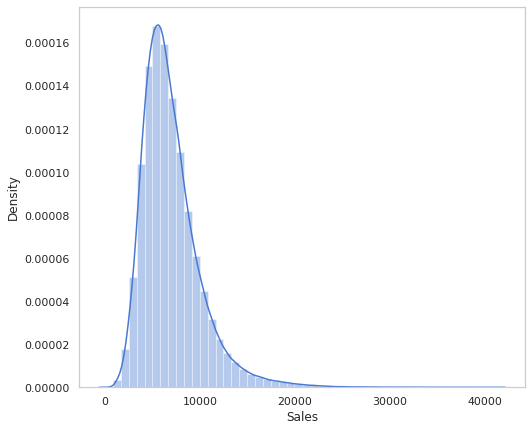

In [99]:
sns.set_theme(rc={'figure.figsize': (8,7)},style='whitegrid',palette='muted')
ax = sns.distplot(rossmann_df['Sales'])
ax.grid(False)

**Finding:** Target Variable is almost normally distributed.

**square-root for moderate skew:** sqrt(x) for positively skewed data, sqrt(max(x+1) - x) for negatively skewed data

In [101]:
rossmann_df['Sales'] = np.sqrt(rossmann_df['Sales'])

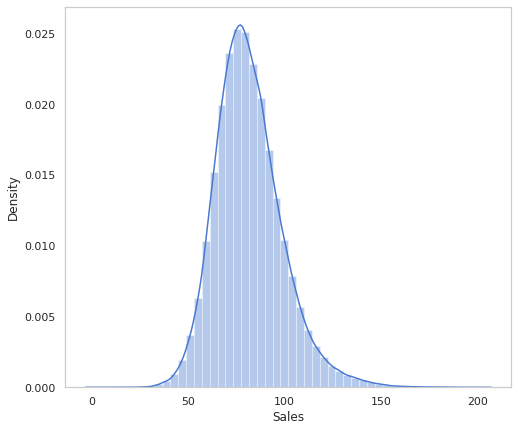

In [102]:
sns.set_theme(rc={'figure.figsize': (8,7)},style='whitegrid',palette='muted')
ax = sns.distplot(rossmann_df['Sales'])
ax.grid(False)

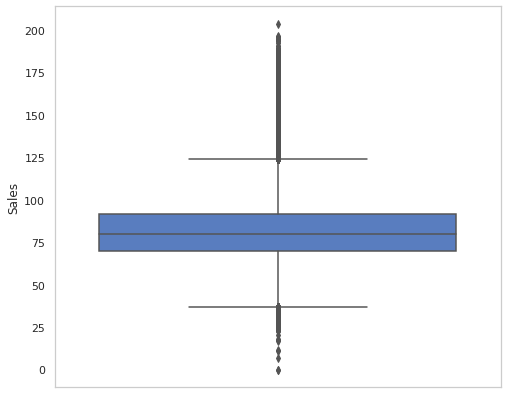

In [103]:
sns.set_theme(rc={'figure.figsize': (8,7)},style='whitegrid',palette='muted')
ax = sns.boxplot(y=rossmann_df['Sales'])
ax.grid(False)

Removing Outlier present in the target variable

In [107]:
percentile_25 = np.percentile(rossmann_df['Sales'],25)
percentile_75 = np.percentile(rossmann_df['Sales'],75)
iqr = (percentile_75 - percentile_25)
upper_outlier_bound = percentile_75 + 1.5*iqr
lower_outlier_bound = percentile_25 - 1.5*iqr

In [108]:
rossmann_df.drop(index=rossmann_df[rossmann_df['Sales']>upper_outlier_bound].index,axis=0,inplace=True)
rossmann_df.drop(index=rossmann_df[rossmann_df['Sales']<lower_outlier_bound].index,axis=0,inplace=True)

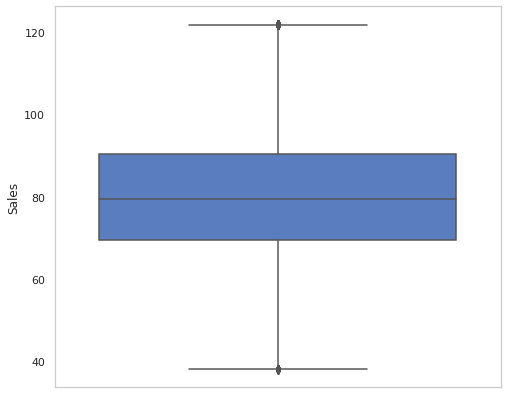

In [109]:
sns.set_theme(rc={'figure.figsize': (8,7)},style='whitegrid',palette='muted')
ax = sns.boxplot(y=rossmann_df['Sales'])
ax.grid(False)

**Numerical features:** -- Custormers


**Categorical features:** -- dayOfWeek,StateHoliday,SchoolHoliday,Promo,date,Open

**Understanding distribution of other numerical features**


Distribution of Customers

---



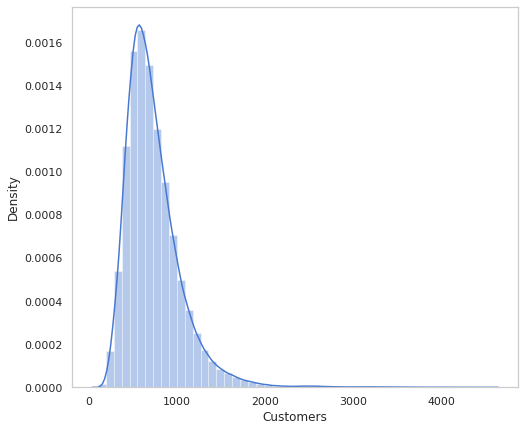

In [111]:
sns.set_theme(rc={'figure.figsize': (8,7)},style='whitegrid',palette='muted')
ax = sns.distplot(rossmann_df['Customers'])
ax.grid(False)

In [112]:
rossmann_df['Customers'] = np.sqrt(rossmann_df['Customers'])

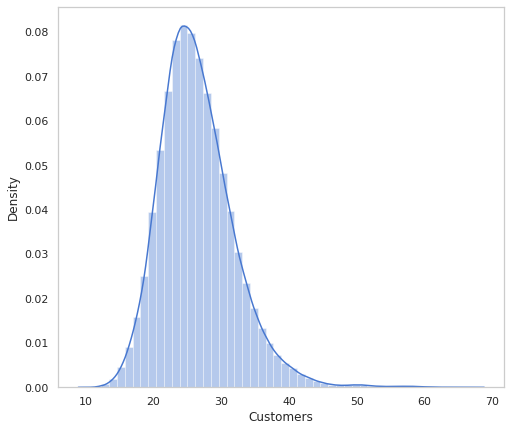

In [113]:
sns.set_theme(rc={'figure.figsize': (8,7)},style='whitegrid',palette='muted')
ax = sns.distplot(rossmann_df['Customers'])
ax.grid(False)

**Validating Linear Relationship between target variable and numerical features**

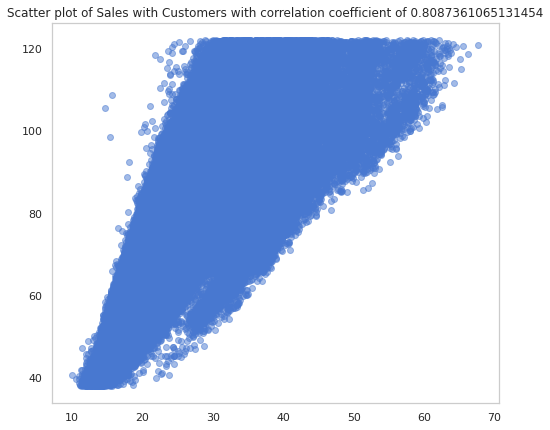

In [114]:
plt.scatter(rossmann_df['Customers'], rossmann_df['Sales'], alpha=0.5)
coeff,_=pearsonr(rossmann_df['Sales'],rossmann_df['Customers'])
plt.title('Scatter plot of Sales with Customers with correlation coefficient of {}'.format(coeff))
plt.grid(False)
plt.show()


**Encoding feature StateHoliday such that 1 correspond to holiday and 0 correspond to none**

In [119]:
def isStateHoliday(x):
  if x == 'a' or x == 'b' or x == 'c':
    return 1
  else:
    return 0
rossmann_df['StateHoliday'] = rossmann_df['StateHoliday'].apply(lambda x: isStateHoliday(x))

In [120]:
rossmann_df['StateHoliday'].unique()

array([0])

**Converting date object to pandas datetime**

In [121]:
rossmann_df['Date'] = pd.to_datetime(rossmann_df['Date'])

In [122]:
rossmann_df['Date'].dtypes

dtype('<M8[ns]')

**Extracting year,week,month from datetime object**

In [123]:

rossmann_df['year'] = rossmann_df['Date'].dt.year
rossmann_df['month'] = rossmann_df['Date'].dt.month
rossmann_df['week'] = rossmann_df['Date'].dt.week

**Dropping column Date from rossmann dataset**

In [124]:
rossmann_df.drop('Date',axis=1,inplace=True)

**Year wise distribution of Sales**

In [125]:
def plotter(StringA , StringB, dataFrame,width,height):
  fig, axes = plt.subplots(3,1)
  fig.set_size_inches(width, height)
  sns.barplot(x=StringA, y=StringB, data=dataFrame , ax = axes[0])
  sns.boxplot(x=StringA, y=StringB, data=dataFrame , ax=axes[1])
  sns.violinplot(x=StringA, y=StringB, data=dataFrame , ax=axes[2])

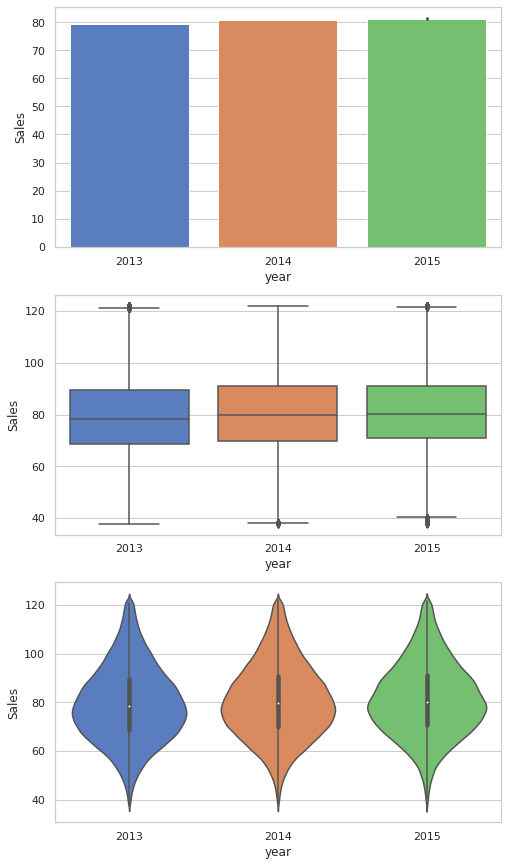

In [126]:
plotter('year','Sales',rossmann_df,8,15)

**Week wise distribution of Sales**

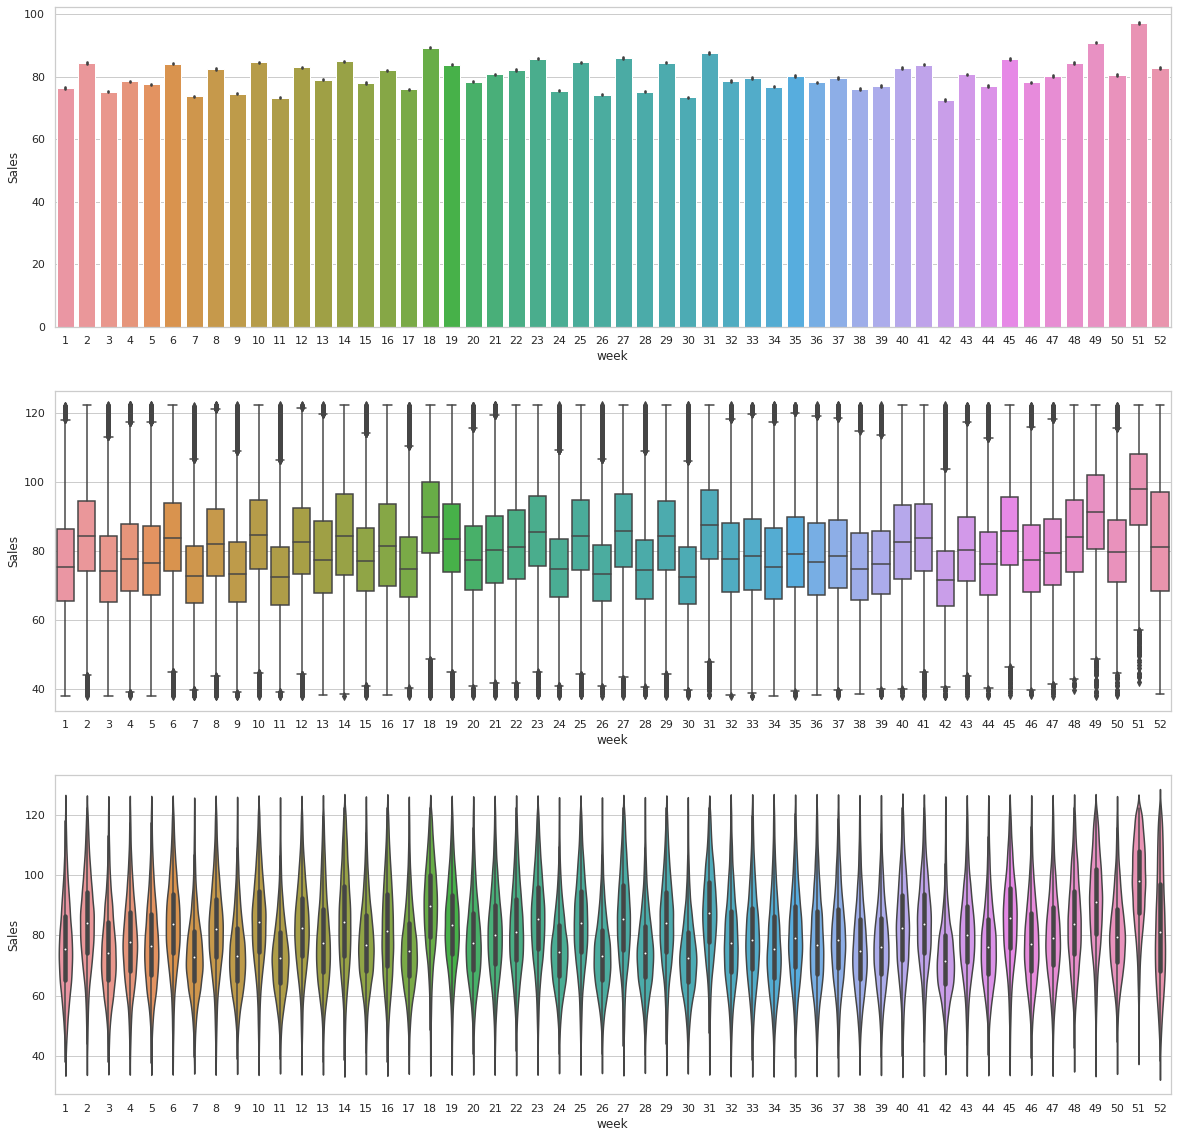

In [127]:
plotter('week','Sales',rossmann_df,20,20)

**Month wise distribution of Sales**

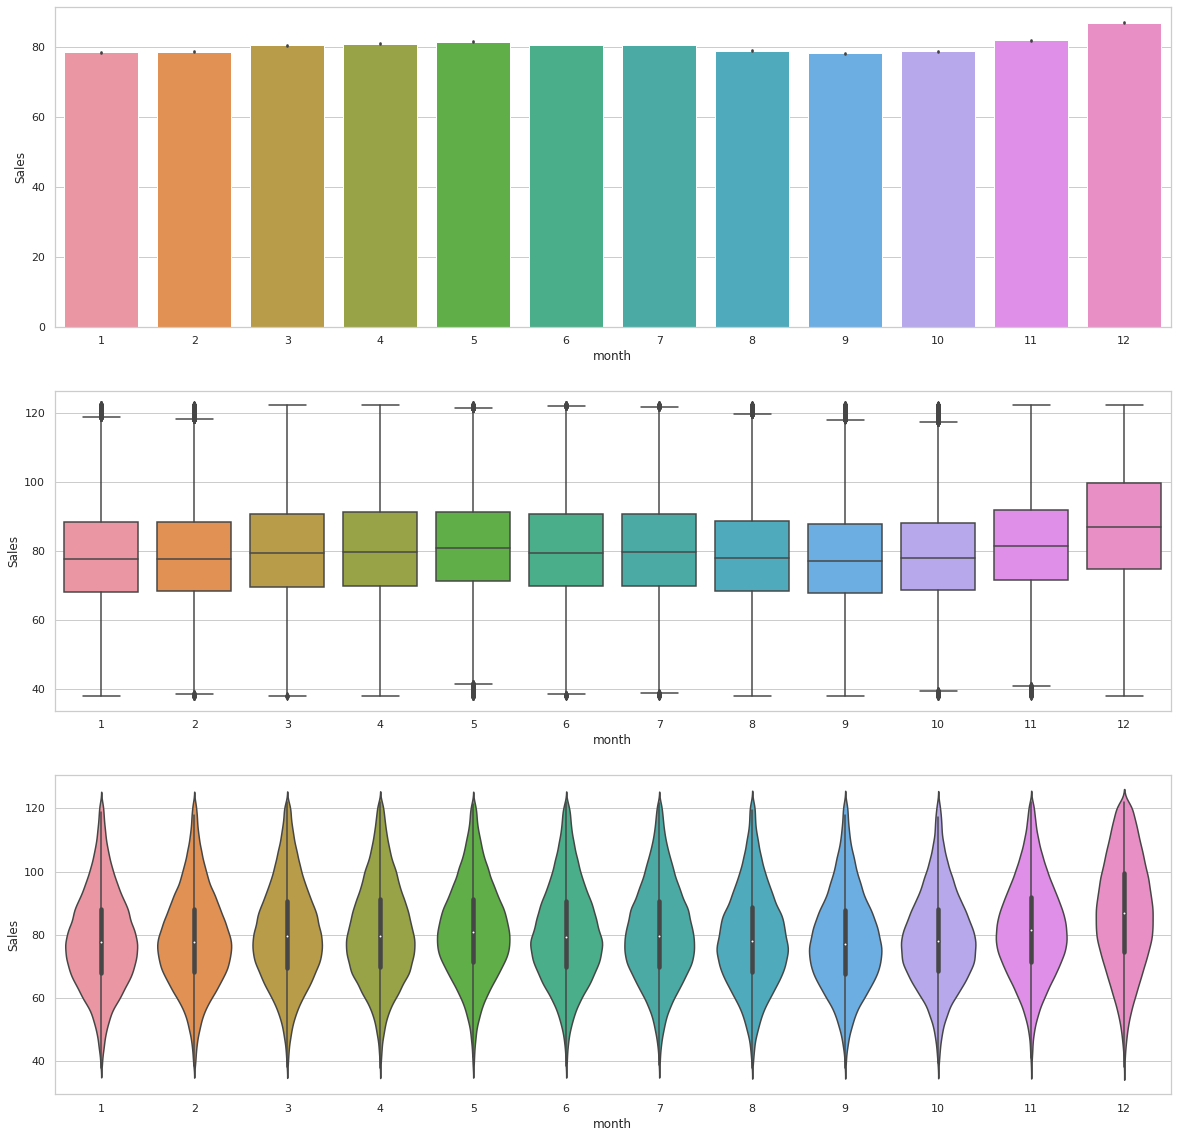

In [128]:
plotter('month','Sales',rossmann_df,20,20)

**dayOfWeek wise distribution of Sales**

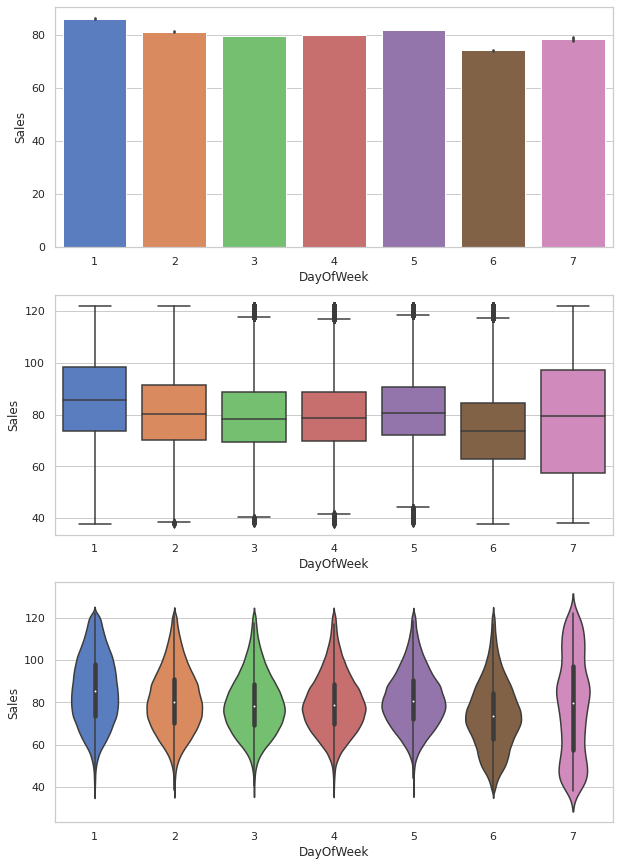

In [129]:
plotter('DayOfWeek','Sales',rossmann_df,10,15)

**Distribution of Sales on the basis of StateHoliday**

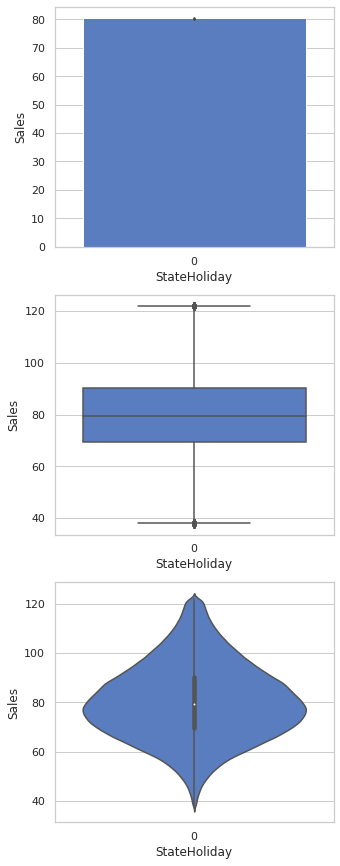

In [133]:
plotter('StateHoliday','Sales',rossmann_df,5,15)

**Distribution of Sales on the basis of SchoolHoliday**

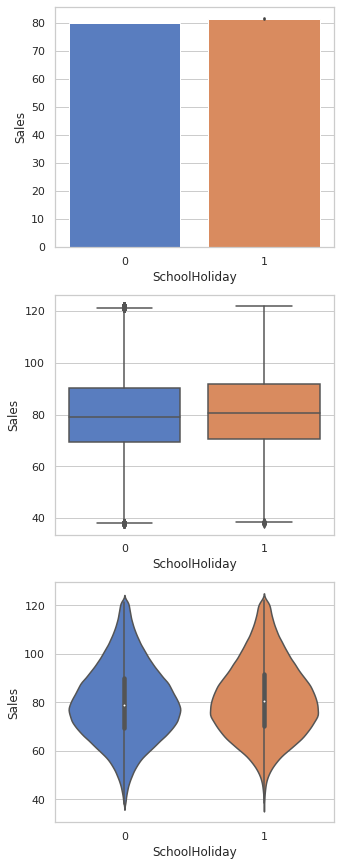

In [131]:
plotter('SchoolHoliday','Sales',rossmann_df,5,15)

**Distribution of Sales on the basis of Promo**

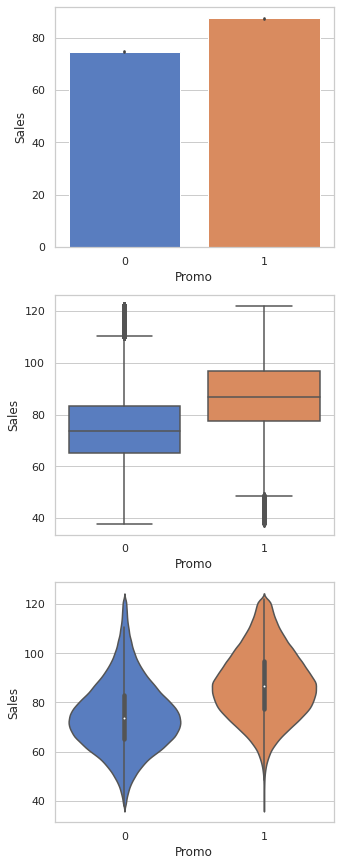

In [132]:
plotter('Promo','Sales',rossmann_df,5,15)

In [171]:
rossmann_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales/Customer,year,month,week
0,1,5,72.546537,23.558438,1,1,0,1,9.482883,2015,7,31
1,2,5,77.871689,25.000000,1,1,0,1,9.702400,2015,7,31
2,3,5,91.181138,28.653098,1,1,0,1,10.126675,2015,7,31
3,4,5,118.300465,38.704005,1,1,0,1,9.342457,2015,7,31
4,5,5,69.440622,23.643181,1,1,0,1,8.626118,2015,7,31


Stores Dataset

Lets first inspect the dataset here the main steps would be:

* Going through the first 5 and bottom 5 rows of the dataset.
* Finding out number of features and number of records present in the dataset.
* Features names present in the dataset.
* Finding out nulls present in the dataset.
* Finding the outlier present.
* Understanding the distribution of variables present in the dataset.
* Finding out the categorical and numerical variable present in the dateset.

**Going through the first 5 and bottom 5 rows of the dataset**

In [172]:
pd.concat([stores_df.head(),stores_df.tail()])

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct"
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct"
4,5,a,a,29910.0,4.0,2015.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct"
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,9.0,2013.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct"
1113,1114,a,c,870.0,9.0,2013.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct"
1114,1115,d,c,5350.0,9.0,2013.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"


**Number of duplicated records present in the dataset**

In [135]:
print('Number of duplicate record present in the dataset is {}'.format(len(stores_df[stores_df.duplicated()])))

Number of duplicate record present in the dataset is 0


**Number of records and number of features present in the dataset**

In [173]:
print('There are {} number of records present in the stores dataset'.format(stores_df.shape[0]))
print('There are {}  features present in the stores dataset'.format(stores_df.shape[1]))

There are 1115 number of records present in the stores dataset
There are 10  features present in the stores dataset


**Features name present in the stores dataset**

In [174]:
for i in stores_df.columns:
  print(i)

Store
StoreType
Assortment
CompetitionDistance
CompetitionOpenSinceMonth
CompetitionOpenSinceYear
Promo2
Promo2SinceWeek
Promo2SinceYear
PromoInterval


**Features datatype present in the dataset**

In [175]:
stores_df.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

**Unique Value Present in Categorical type features**

In [176]:
categorical_features = [i for i in stores_df.columns if stores_df[i].dtypes == object]
for i in categorical_features:
  print('Unique Elements present in {} are'.format(i))
  print(stores_df[i].unique())

Unique Elements present in StoreType are
['c' 'a' 'd' 'b']
Unique Elements present in Assortment are
['a' 'c' 'b']
Unique Elements present in PromoInterval are
['Jan,Apr,Jul,Oct' 'Feb,May,Aug,Nov' 'Mar,Jun,Sept,Dec']


**Percent of Null Values for each features present in the dataset**



In [177]:
for i in stores_df.columns:
  percent = round((stores_df[i].isnull().sum()/len(stores_df))*100,2)
  print('Nullvalue percentage for feature {} is {}%'.format(i,percent))

Nullvalue percentage for feature Store is 0.0%
Nullvalue percentage for feature StoreType is 0.0%
Nullvalue percentage for feature Assortment is 0.0%
Nullvalue percentage for feature CompetitionDistance is 0.0%
Nullvalue percentage for feature CompetitionOpenSinceMonth is 0.0%
Nullvalue percentage for feature CompetitionOpenSinceYear is 0.0%
Nullvalue percentage for feature Promo2 is 0.0%
Nullvalue percentage for feature Promo2SinceWeek is 0.0%
Nullvalue percentage for feature Promo2SinceYear is 0.0%
Nullvalue percentage for feature PromoInterval is 0.0%


**Replacing nan value present in CompetationDistance with mean**

In [178]:
stores_df['CompetitionDistance'].fillna(stores_df['CompetitionDistance'].mean(),inplace=True)
stores_df['CompetitionDistance'].isna().sum()

0

**Replacing nan value present in other features with their respective mode**

In [179]:
stores_df['CompetitionOpenSinceYear'].fillna(stores_df['CompetitionOpenSinceYear'].mode()[0],inplace=True)
stores_df['CompetitionOpenSinceMonth'].fillna(stores_df['CompetitionOpenSinceMonth'].mode()[0],inplace=True)
stores_df['Promo2SinceWeek'].fillna(stores_df['Promo2SinceWeek'].mode()[0],inplace=True)
stores_df['Promo2SinceYear'].fillna(stores_df['Promo2SinceYear'].mode()[0],inplace=True)
stores_df['PromoInterval'].fillna(stores_df['PromoInterval'].mode()[0],inplace=True)

**Merging the Rossmann dataset with Stores Dataset**

In [180]:
merge_df = pd.merge(left=rossmann_df,right=stores_df,how='left',on='Store')
merge_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales/Customer,year,month,week,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,72.546537,23.558438,1,1,0,1,9.482883,2015,7,31,c,a,1270.0,9.0,2008.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct"
1,2,5,77.871689,25.000000,1,1,0,1,9.702400,2015,7,31,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,91.181138,28.653098,1,1,0,1,10.126675,2015,7,31,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,118.300465,38.704005,1,1,0,1,9.342457,2015,7,31,c,c,620.0,9.0,2009.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct"
4,5,5,69.440622,23.643181,1,1,0,1,8.626118,2015,7,31,a,a,29910.0,4.0,2015.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct"


**Distribution of Competition Distance**

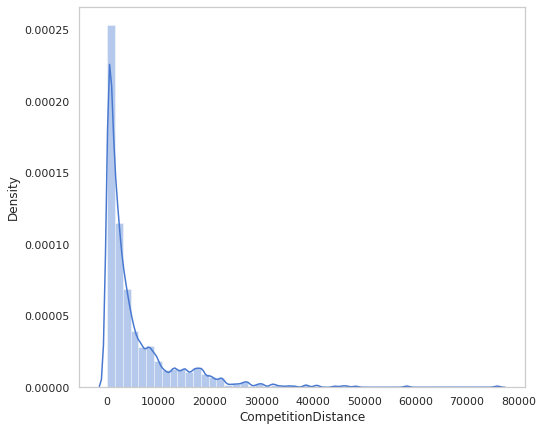

In [181]:
sns.set_theme(rc={'figure.figsize': (8,7)},style='whitegrid',palette='muted')
ax = sns.distplot(merge_df['CompetitionDistance'])
ax.grid(False)

**Transformation** log(x) for positively skewed data

In [182]:
merge_df['CompetitionDistance'] = np.log(merge_df['CompetitionDistance'])

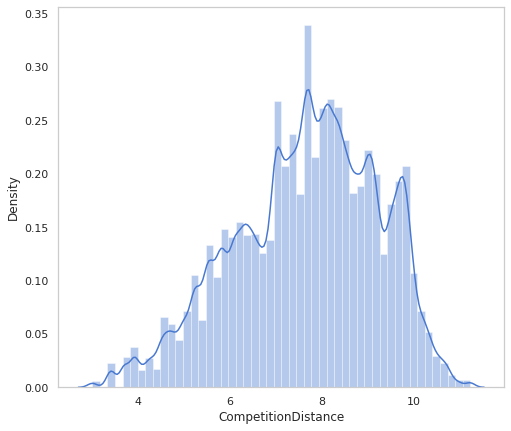

In [183]:
sns.set_theme(rc={'figure.figsize': (8,7)},style='whitegrid',palette='muted')
ax = sns.distplot(merge_df['CompetitionDistance'])
ax.grid(False)

**Validating the linear relationship between target variable and Competition distance**

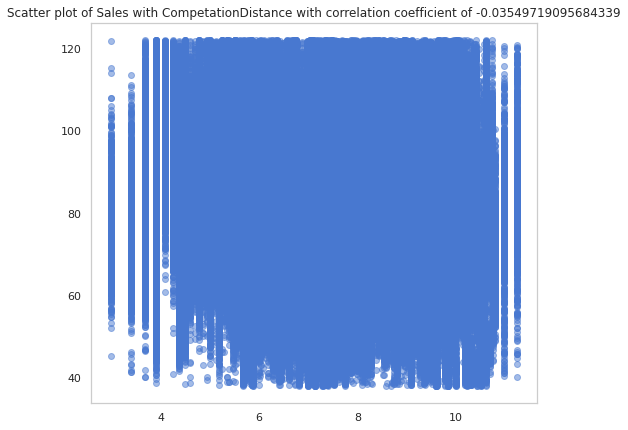

In [197]:
plt.scatter(merge_df['CompetitionDistance'], rossmann_df['Sales'], alpha=0.5)
coeff,_=pearsonr(merge_df['Sales'],merge_df['CompetitionDistance'])
plt.title('Scatter plot of Sales with CompetationDistance with correlation coefficient of {}'.format(coeff))
plt.grid(False)
plt.show()

**Finding:** As there is almost no correlationship between them therefore we will drop this feature

In [198]:
final_df = merge_df.copy()
final_df.drop('CompetitionDistance',axis=1,inplace=True)

In [199]:
final_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales/Customer,year,month,week,StoreType,Assortment,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,72.546537,23.558438,1,1,0,1,9.482883,2015,7,31,c,a,9.0,2008.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct"
1,2,5,77.871689,25.000000,1,1,0,1,9.702400,2015,7,31,a,a,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,91.181138,28.653098,1,1,0,1,10.126675,2015,7,31,a,a,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,118.300465,38.704005,1,1,0,1,9.342457,2015,7,31,c,c,9.0,2009.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct"
4,5,5,69.440622,23.643181,1,1,0,1,8.626118,2015,7,31,a,a,4.0,2015.0,0,14.0,2011.0,"Jan,Apr,Jul,Oct"


**Distribution of Sales on the basis of Competition Since Year**

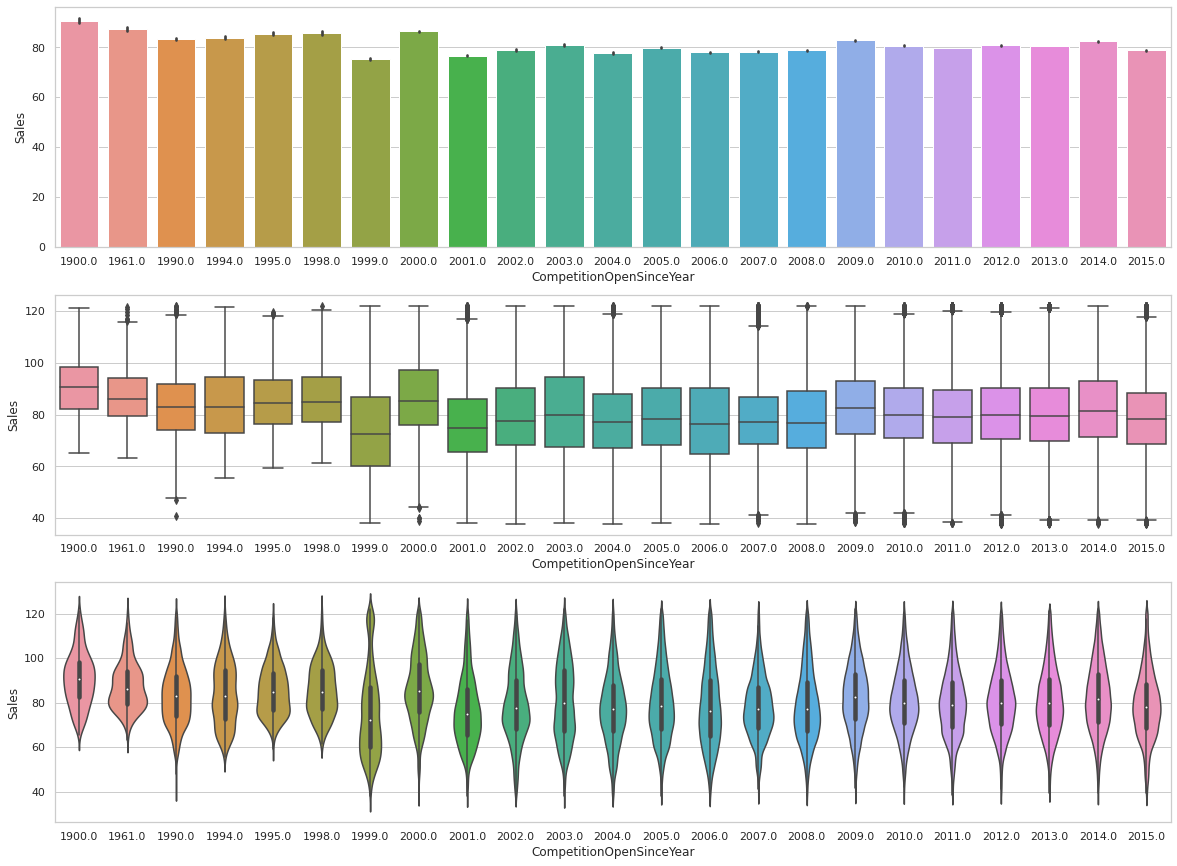

In [200]:
plotter('CompetitionOpenSinceYear','Sales',final_df,20,15)

**Distribution of Sales on the basis of StoreType**

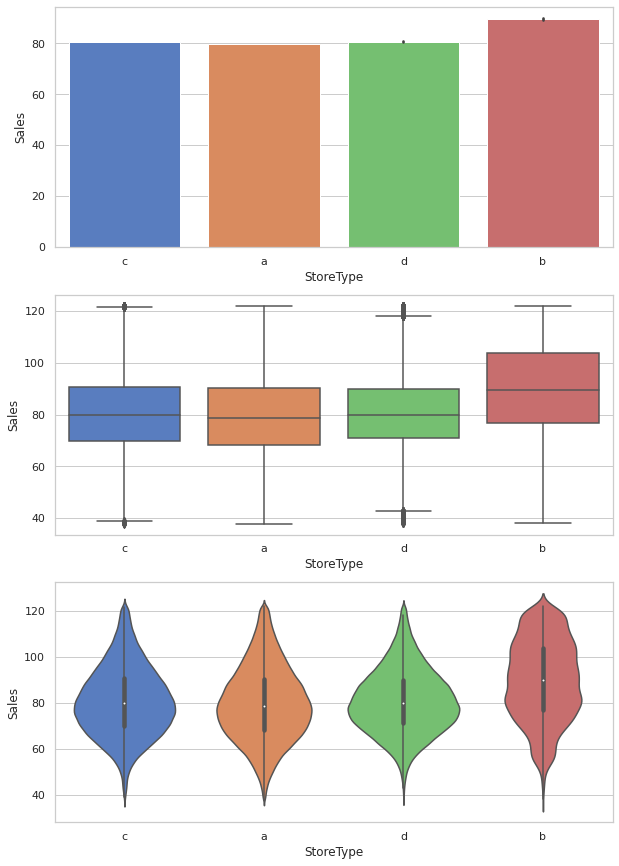

In [201]:
plotter('StoreType','Sales',final_df,10,15)

**Distribution of Sales on the basis of Assortment**

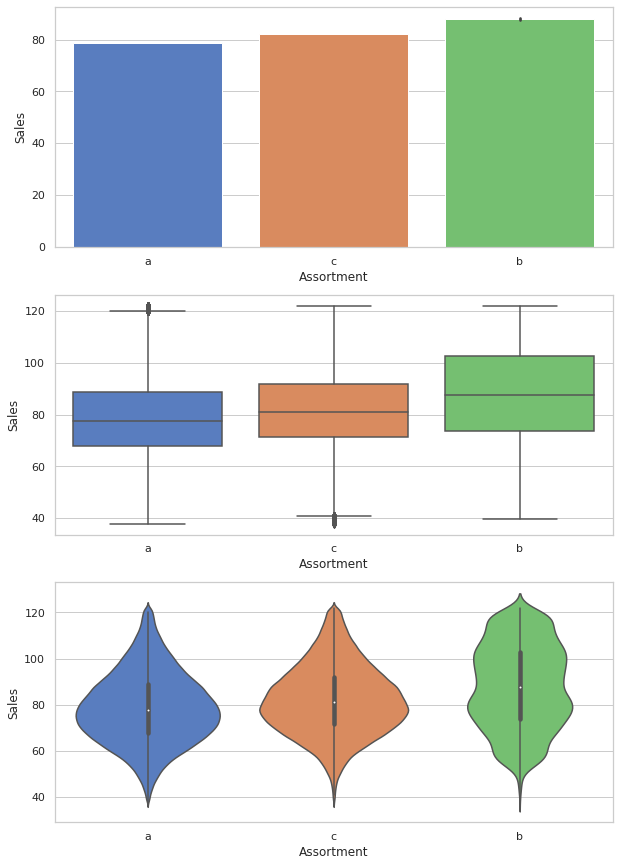

In [202]:
plotter('Assortment','Sales',final_df,10,15)

**One hot encoding for categorical features like StoreType, Assortment, PromoInterval**

In [203]:
main_df = pd.get_dummies(final_df, columns = ['StoreType', 'Assortment', 'PromoInterval'])
main_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales/Customer,year,month,week,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
0,1,5,72.546537,23.558438,1,1,0,1,9.482883,2015,7,31,9.0,2008.0,0,14.0,2011.0,0,0,1,0,1,0,0,0,1,0
1,2,5,77.871689,25.000000,1,1,0,1,9.702400,2015,7,31,11.0,2007.0,1,13.0,2010.0,1,0,0,0,1,0,0,0,1,0
2,3,5,91.181138,28.653098,1,1,0,1,10.126675,2015,7,31,12.0,2006.0,1,14.0,2011.0,1,0,0,0,1,0,0,0,1,0
3,4,5,118.300465,38.704005,1,1,0,1,9.342457,2015,7,31,9.0,2009.0,0,14.0,2011.0,0,0,1,0,0,0,1,0,1,0
4,5,5,69.440622,23.643181,1,1,0,1,8.626118,2015,7,31,4.0,2015.0,0,14.0,2011.0,1,0,0,0,1,0,0,0,1,0


**Dropping Columns Store and Sales/Customer**

In [204]:
main_df.drop(['Store','Sales/Customer'],axis=1,inplace=True)

**Breaking the dataset into predictor and target variable**

In [214]:
X = main_df[[i for i in main_df.columns if i not in ['Sales']]]
Y = main_df['Sales']

**Normalizing the predictor variables**

In [213]:
scaler = MinMaxScaler()
# transform data
scaled_X = scaler.fit_transform(X)

**Train Test Split with test size 0.2 and random state 7**

In [212]:
X_train, X_test, y_train, y_test = train_test_split(scaled_X,Y,test_size=0.2,random_state=7)

**Training with Linear Regression Model**

In [211]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X_train , y_train)
pred_train = reg.predict(X_train)
pred_test = reg.predict(X_test)

**Linear Regression Model Evaluation**

In [220]:
print('-----------Mean Squared Error------------')
print('Training Data Set mean square error is: {}'.format(mean_squared_error(y_train**2,pred_train**2)))
print('Test Data Set mean sqaure error is {}'.format(mean_squared_error(y_test**2,pred_test**2)))
print('-----------------------------------------')
print('-----------Root Mean Squared Error----------')
rmse_train = np.sqrt(mean_squared_error(y_train**2,pred_train**2))
rmse_test = np.sqrt(mean_squared_error(y_test**2,pred_test**2))
print('Training Data Set rmse is {}'.format(rmse_train))
print('Test Data Set rmse is {}'.format(rmse_test))
print('--------------------------------------------')
print('--------------r2_Score---------------------')
print('r2_score for training dataset is {}'.format(r2_score(y_train**2,pred_train**2)))
print('r2_score for test dataset is {}'.format(r2_score(y_test**2,pred_test**2)))

-----------Mean Squared Error------------
Training Data Set mean square error is: 1269371.9034434068
Test Data Set mean sqaure error is 1280592.156809413
-----------------------------------------
-----------Root Mean Squared Error----------
Training Data Set rmse is 1126.6640597105275
Test Data Set rmse is 1131.6325184481989
--------------------------------------------
--------------r2_Score---------------------
r2_score for training dataset is 0.8038204316264044
r2_score for test dataset is 0.8035466828459035


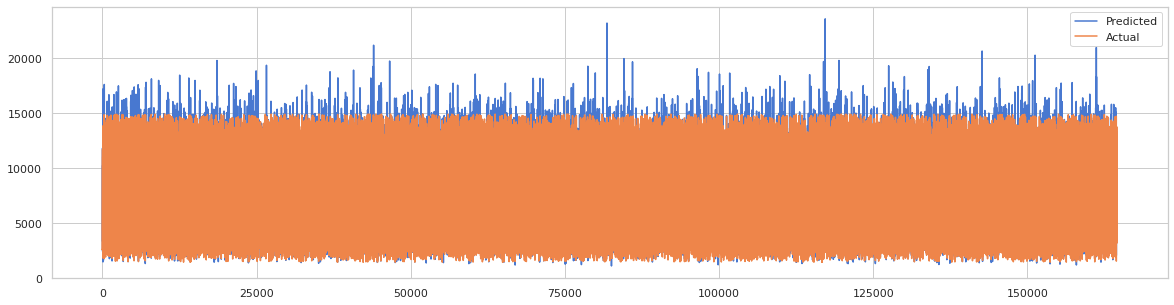

In [221]:
plt.figure(figsize=(20,5))
plt.plot((pred_test)**2)
plt.plot(np.array((y_test)**2))
plt.legend(["Predicted","Actual"])
plt.show()

**Implementing Lasso regression with cross-validation and hyper parameter tuning**

In [231]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
lasso = Lasso()
parameters = {'alpha': [1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,45,50,55,60,100]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1, 1, 5, 10, 20, 30, 40, 45,
                                   50, 55, 60, 100]},
             scoring='neg_mean_squared_error')

In [232]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1e-15}

Using  {'alpha': 1e-15}  the negative mean squared error is:  -42.46926917647481


In [233]:
y_pred_lasso = lasso_regressor.predict(X_test)

In [223]:
lasso.score(X_train, y_train)

0.8008659900600128

In [224]:
y_pred_l = lasso.predict(X_test)

In [234]:
MSE  = mean_squared_error((y_test)**2, (y_pred_lasso)**2)
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((y_test)**2, (y_pred_lasso)**2)
print("R2 :" ,r2)

MSE : 1280656.7975794044
RMSE : 1131.6610789363592
R2 : 0.8035367664227702


**Implementing Ridge Regression with cross-validation and hyper parameter tuning**

In [236]:
ridge = Ridge()
parameters = {'alpha': [1e-15,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,45,50,55,60,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=3)
ridge_regressor.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 1e-05, 0.0001, 0.001,
                                   0.01, 1, 5, 10, 20, 30, 40, 45, 50, 55, 60,
                                   100]},
             scoring='neg_mean_squared_error')

In [237]:
ridge_regressor.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 1e-05, 0.0001, 0.001,
                                   0.01, 1, 5, 10, 20, 30, 40, 45, 50, 55, 60,
                                   100]},
             scoring='neg_mean_squared_error')

In [238]:
ridge_regressor.score(X_train, y_train)

-42.46661438149712

In [240]:
y_pred_ridge = ridge_regressor.predict(X_test)

In [246]:
MSE  = mean_squared_error((y_test)**2, (y_pred_ridge)**2)
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((y_test)**2, (y_pred_ridge)**2)
print("R2 :" ,r2)

MSE : 1280656.4128873073
RMSE : 1131.660908968454
R2 : 0.8035368254376861
